# Demo for using the PIBC
Demonstration for how to use the PIBC measure to evaluate how important each predictor in a random forrest is to predicting each class.

Start by creating a random forest classifier with Sci-Kit Learn. We'll use the iris dataset for demonstration.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt
import importanceMatrix

In [2]:
iris = load_iris()

X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

One cruicial issue to note about the PIBC (or any such method) is that it does not tell you anything about the accuracy of your classifier. If the classifier has poor accuracy, then knowing how important a given predictor is to predicting a given class is not very informative. The PIBC requires the classifier it investigates to perform well for it to be informative.

Let's quickly evaluate the performance of the classifier to see if it is doing well enough to merit investigation with the PIBC.

In [3]:
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 

# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

Mean Absolute Error: 0.0
Model Accuracy: 100.0


The model is very accurate, so it is reasonable and informative to proceed with calculating predictor importances by class. We can do this by passing the classifier to the `calcImportanceMatrix` function from `importanceMatrix`.

In [6]:
###OLD PER-CLASS IMPORTANCE FUNCTION
def calcImportanceMatrix_old(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must be a RandomForestClassifier object.

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class. A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    for dec_tree in rf_clf.estimators_:
        
        # get the number of features used in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        
        for par_ind,node in enumerate(nodes):
            parent_node_ind[node[0]] = par_ind
            parent_node_ind[node[1]] = par_ind

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==node[1] for node in nodes])
        leaves_index = np.nonzero(is_leaves)[0]

        leaves_parent = parent_node_ind[is_leaves]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        leaves_class_index = node_pred[is_leaves]

        ### TO BE SANITY-CHECKED
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            parent_i = parent_node_ind[leaf_i]
            current_i = leaf_i

            # walk the tree and calculate the importance of the predictor
            while parent_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * current_node['impurity'] -
                        left_node['weighted_n_node_samples'] * left_node['impurity'] -
                        right_node['weighted_n_node_samples'] * right_node['impurity']
                        )
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_i
                parent_i = parent_node_ind[current_i]
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])

    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    return(importance_matrix)

In [9]:
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()

def f_entropy(v):
    return sps.entropy(pk=v)

def f_misclassification(v):
    p = v/v.sum()
    return 1 - p.max()

In [6]:
###THIS CELL WAS USED TO DEBUG THE CODE
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()

def f_entropy(v):
    return sps.entropy(pk=v)

def f_misclassification(v):
    p = v/v.sum()
    return 1 - p.max()

### AGGIUNGERE MSE=MEAN SQUARE ERROR; FRIEDMAN_MSE; MAE = MEAN ABSOLUTE ERROR.

# get the number of classes being predicted by the random forest
classes = rf_clf.classes_
n_classes = len(classes)

# init storage for the predictor importances by classes by trees
importance_matrix = []

dec_tree = rf_clf.estimators_[0]


for dec_tree in rf_clf.estimators_:

    # get the criterion used to measure impurity
    criterion = dec_tree.get_params()['criterion']
    if criterion == 'gini':
        f_impurity = f_gini
    elif criterion == 'entropy':
        f_impurity = f_entropy
    elif criterion == 'misclassification':
        f_impurity = f_misclassification
    else:
        f_impurity = 0
        print('Unassigned impurity measure')

    # get the number of features and nodes in the tree
    feature = dec_tree.tree_.feature
    n_features = dec_tree.tree_.n_features
    n_nodes = dec_tree.tree_.__getstate__()['node_count']
    nodes = dec_tree.tree_.__getstate__()['nodes']
    parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
    #parent_node_ind[0] = n_nodes + 1
    #print(parent_node_ind)
    for par_ind,node in enumerate(nodes):
        if node[0] != -1:
            parent_node_ind[node[0]] = par_ind
        if node[1] != -1:
            parent_node_ind[node[1]] = par_ind
    #print(parent_node_ind)

    # identify the leaves of the tree
    is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])

    leaves_index = np.nonzero(is_leaves)[0]



    values_sorted = dec_tree.tree_.__getstate__()['values']
    #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
    node_pred = np.argmax(values_sorted[:,0,:], axis=1)
    leaves_class_index = node_pred[is_leaves]

    for par_ind,node in enumerate(nodes):
        print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
              values_sorted[par_ind], values_sorted[par_ind].sum())

    ### TO BE SANITY-CHECKED
    node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
    tree_importances = np.zeros((n_classes, n_features))
    for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
        ###v1_initialisation###parent_i = parent_node_ind[leaf_i]
        ###v1_initialisation###current_i = leaf_i
        current_i = parent_node_ind[leaf_i]
        print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
        print('whose parent is ', current_i)
        # walk the tree and calculate the importance of the predictor
        ###v1_initialisation###while parent_i != -1 and node_unvisited[leaf_c_i,current_i]:
        while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
            current_node = nodes[current_i]
            left_node = nodes[current_node['left_child']]
            right_node = nodes[current_node['right_child']]
            current_feature = current_node['feature']
            #tree_importances[leaf_c_i,current_feature] += (
            #        current_node['weighted_n_node_samples'] * current_node['impurity'] -
            #        left_node['weighted_n_node_samples'] * left_node['impurity'] -
            #        right_node['weighted_n_node_samples'] * right_node['impurity']
            #        )
            ###NEW HERE
            current_values = values_sorted[current_i,0,:]
            left_values = values_sorted[current_node['left_child'],0,:]
            right_values = values_sorted[current_node['right_child'],0,:]

            current_values_class = np.array([
                current_values[leaf_c_i],
                current_values[np.arange(len(current_values)) != leaf_c_i].sum()
            ])
            left_values_class = np.array([
                left_values[leaf_c_i],
                left_values[np.arange(len(left_values)) != leaf_c_i].sum()
            ])
            right_values_class = np.array([
                right_values[leaf_c_i],
                right_values[np.arange(len(right_values)) != leaf_c_i].sum()
            ])
            print(
                current_values,
                np.array([current_values[leaf_c_i], current_values[np.arange(len(current_values))!=leaf_c_i].sum()])
                 )
            #print(current_values.sum(), left_values.sum(), right_values.sum(),
            #     left_values.sum()/current_values.sum(), right_values.sum()/current_values.sum(),
            #      current_node['weighted_n_node_samples'], left_node['weighted_n_node_samples'],
            #      right_node['weighted_n_node_samples']
            #     )
            tree_importances[leaf_c_i,current_feature] += (
                    current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                    left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                    right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                    )
            #print('\n', current_node, (
            #        current_node['weighted_n_node_samples'] * f_importance(current_values) -
            #        left_node['weighted_n_node_samples'] * f_importance(left_values) -
            #        right_node['weighted_n_node_samples'] * f_importance(right_values)
            #        ))
            ###
            node_unvisited[leaf_c_i,current_i] = False
            ###v1###current_i = parent_i
            ###v1###parent_i = parent_node_ind[current_i]
            current_i = parent_node_ind[current_i]
            print('next current is ', current_i)
    importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])

# average the predictor importances for each class by all of the trees in the forest
importance_matrix = np.mean(importance_matrix, axis = 0)

0 -1 False (1, 16, 3, 1.75, 0.63839286, 71, 112.) [[22. 46. 44.]] 112.0
1 0 False (2, 3, 3, 0.7, 0.51118827, 46, 72.) [[22. 45.  5.]] 72.0
2 1 True (-1, -1, -2, -2., 0., 17, 22.) [[22.  0.  0.]] 22.0
3 1 False (4, 11, 2, 5.04999995, 0.18, 29, 50.) [[ 0. 45.  5.]] 50.0
4 3 False (5, 8, 3, 1.65000004, 0.0831758, 25, 46.) [[ 0. 44.  2.]] 46.0
5 4 False (6, 7, 2, 4.95000005, 0.04542996, 23, 43.) [[ 0. 42.  1.]] 43.0
6 5 True (-1, -1, -2, -2., 0., 22, 42.) [[ 0. 42.  0.]] 42.0
7 5 True (-1, -1, -2, -2., 0., 1, 1.) [[0. 0. 1.]] 1.0
8 4 False (9, 10, 2, 4.75, 0.44444444, 2, 3.) [[0. 2. 1.]] 3.0
9 8 True (-1, -1, -2, -2., 0., 1, 1.) [[0. 0. 1.]] 1.0
10 8 True (-1, -1, -2, -2., 0., 1, 2.) [[0. 2. 0.]] 2.0
11 3 False (12, 13, 3, 1.55000001, 0.375, 4, 4.) [[0. 1. 3.]] 4.0
12 11 True (-1, -1, -2, -2., 0., 2, 2.) [[0. 0. 2.]] 2.0
13 11 False (14, 15, 2, 5.45000005, 0.5, 2, 2.) [[0. 1. 1.]] 2.0
14 13 True (-1, -1, -2, -2., 0., 1, 1.) [[0. 1. 0.]] 1.0
15 13 True (-1, -1, -2, -2., 0., 1, 1.) [[0. 0. 1

15 11 True (-1, -1, -2, -2., 0., 2, 2.) [[0. 0. 2.]] 2.0
16 10 True (-1, -1, -2, -2., 0., 24, 40.) [[ 0.  0. 40.]] 40.0
START from leaf  2 with class  0
whose parent is  1
[24.  4.  2.] [24.  6.]
next current is  0
[26. 41. 45.] [26. 86.]
next current is  -1
START from leaf  4 with class  1
whose parent is  3
[0. 4. 2.] [4. 2.]
next current is  1
[24.  4.  2.] [ 4. 26.]
next current is  0
[26. 41. 45.] [41. 71.]
next current is  -1
START from leaf  5 with class  2
whose parent is  3
[0. 4. 2.] [2. 4.]
next current is  1
[24.  4.  2.] [ 2. 28.]
next current is  0
[26. 41. 45.] [45. 67.]
next current is  -1
START from leaf  8 with class  1
whose parent is  7
[ 2. 36.  0.] [36.  2.]
next current is  6
[ 2. 37. 43.] [37. 45.]
next current is  0
START from leaf  9 with class  0
whose parent is  7
[ 2. 36.  0.] [ 2. 36.]
next current is  6
[ 2. 37. 43.] [ 2. 80.]
next current is  0
START from leaf  13 with class  2
whose parent is  12
[0. 1. 1.] [1. 1.]
next current is  11
[0. 1. 3.] [3. 1.]

[0. 4. 5.] [4. 5.]
next current is  6
[ 0.  4. 42.] [ 4. 42.]
next current is  2
START from leaf  9 with class  2
whose parent is  7
[0. 4. 5.] [5. 4.]
next current is  6
[ 0.  4. 42.] [42.  4.]
next current is  2
START from leaf  10 with class  2
whose parent is  6
0 -1 False (1, 2, 2, 2.69999999, 0.65162628, 67, 112.) [[29. 48. 35.]] 112.0
1 0 True (-1, -1, -2, -2., 0., 22, 29.) [[29.  0.  0.]] 29.0
2 0 False (3, 12, 2, 5.14999986, 0.48773407, 45, 83.) [[ 0. 48. 35.]] 83.0
3 2 False (4, 5, 2, 4.75, 0.22214876, 30, 55.) [[ 0. 48.  7.]] 55.0
4 3 True (-1, -1, -2, -2., 0., 20, 38.) [[ 0. 38.  0.]] 38.0
5 3 False (6, 9, 3, 1.69999999, 0.48442907, 10, 17.) [[ 0. 10.  7.]] 17.0
6 5 False (7, 8, 1, 2.35000002, 0.29752066, 4, 11.) [[0. 9. 2.]] 11.0
7 6 True (-1, -1, -2, -2., 0., 1, 2.) [[0. 0. 2.]] 2.0
8 6 True (-1, -1, -2, -2., 0., 3, 9.) [[0. 9. 0.]] 9.0
9 5 False (10, 11, 1, 3.10000002, 0.27777778, 6, 6.) [[0. 1. 5.]] 6.0
10 9 True (-1, -1, -2, -2., 0., 5, 5.) [[0. 0. 5.]] 5.0
11 9 True (

0 -1 False (1, 2, 3, 0.7, 0.66278699, 71, 112.) [[34. 43. 35.]] 112.0
1 0 True (-1, -1, -2, -2., 0., 23, 34.) [[34.  0.  0.]] 34.0
2 0 False (3, 4, 2, 4.75, 0.4947403, 48, 78.) [[ 0. 43. 35.]] 78.0
3 2 True (-1, -1, -2, -2., 0., 22, 40.) [[ 0. 40.  0.]] 40.0
4 2 False (5, 14, 0, 6.04999995, 0.14542936, 26, 38.) [[ 0.  3. 35.]] 38.0
5 4 False (6, 7, 0, 5.85000014, 0.39669421, 7, 11.) [[0. 3. 8.]] 11.0
6 5 True (-1, -1, -2, -2., 0., 2, 4.) [[0. 0. 4.]] 4.0
7 5 False (8, 11, 2, 5.04999995, 0.48979592, 5, 7.) [[0. 3. 4.]] 7.0
8 7 False (9, 10, 0, 5.95000005, 0.44444444, 3, 3.) [[0. 1. 2.]] 3.0
9 8 True (-1, -1, -2, -2., 0., 1, 1.) [[0. 1. 0.]] 1.0
10 8 True (-1, -1, -2, -2., 0., 2, 2.) [[0. 0. 2.]] 2.0
11 7 False (12, 13, 1, 2.85000002, 0.5, 2, 4.) [[0. 2. 2.]] 4.0
12 11 True (-1, -1, -2, -2., 0., 1, 2.) [[0. 2. 0.]] 2.0
13 11 True (-1, -1, -2, -2., 0., 1, 2.) [[0. 0. 2.]] 2.0
14 4 True (-1, -1, -2, -2., 0., 19, 27.) [[ 0.  0. 27.]] 27.0
START from leaf  1 with class  0
whose parent is  0


[0. 1. 1.] [1. 1.]
next current is  10
START from leaf  15 with class  2
whose parent is  9
START from leaf  16 with class  1
whose parent is  8
START from leaf  17 with class  1
whose parent is  7
START from leaf  18 with class  2
whose parent is  6
0 -1 False (1, 2, 2, 2.44999999, 0.65513393, 69, 112.) [[37. 46. 29.]] 112.0
1 0 True (-1, -1, -2, -2., 0., 23, 37.) [[37.  0.  0.]] 37.0
2 0 False (3, 4, 2, 4.75, 0.47431111, 46, 75.) [[ 0. 46. 29.]] 75.0
3 2 True (-1, -1, -2, -2., 0., 22, 39.) [[ 0. 39.  0.]] 39.0
4 2 False (5, 10, 1, 3.04999995, 0.3132716, 24, 36.) [[ 0.  7. 29.]] 36.0
5 4 False (6, 9, 3, 1.75, 0.24489796, 18, 28.) [[ 0.  4. 24.]] 28.0
6 5 False (7, 8, 1, 2.35000002, 0.32, 4, 5.) [[0. 4. 1.]] 5.0
7 6 True (-1, -1, -2, -2., 0., 1, 1.) [[0. 0. 1.]] 1.0
8 6 True (-1, -1, -2, -2., 0., 3, 4.) [[0. 4. 0.]] 4.0
9 5 True (-1, -1, -2, -2., 0., 14, 23.) [[ 0.  0. 23.]] 23.0
10 4 False (11, 12, 2, 5.25, 0.46875, 6, 8.) [[0. 3. 5.]] 8.0
11 10 True (-1, -1, -2, -2., 0., 2, 3.) [[0. 

whose parent is  10
[ 1. 27.  0.] [ 1. 27.]
next current is  9
[ 1. 27.  6.] [ 1. 33.]
next current is  8
[ 1. 45. 38.] [ 1. 83.]
next current is  0
START from leaf  12 with class  1
whose parent is  10
[ 1. 27.  0.] [27.  1.]
next current is  9
[ 1. 27.  6.] [27.  7.]
next current is  8
[ 1. 45. 38.] [45. 39.]
next current is  0
START from leaf  13 with class  2
whose parent is  9
[ 1. 27.  6.] [ 6. 28.]
next current is  8
[ 1. 45. 38.] [38. 46.]
next current is  0
START from leaf  16 with class  1
whose parent is  15
[ 0. 18.  5.] [18.  5.]
next current is  14
[ 0. 18. 32.] [18. 32.]
next current is  8
START from leaf  18 with class  2
whose parent is  17
[0. 2. 5.] [5. 2.]
next current is  15
[ 0. 18.  5.] [ 5. 18.]
next current is  14
[ 0. 18. 32.] [32. 18.]
next current is  8
START from leaf  20 with class  2
whose parent is  19
[0. 2. 2.] [2. 2.]
next current is  17
START from leaf  21 with class  1
whose parent is  19
[0. 2. 2.] [2. 2.]
next current is  17
[0. 2. 5.] [2. 5.]
nex

9 8 True (-1, -1, -2, -2., 0., 1, 1.) [[0. 0. 1.]] 1.0
10 8 True (-1, -1, -2, -2., 0., 2, 2.) [[0. 2. 0.]] 2.0
11 7 True (-1, -1, -2, -2., 0., 1, 3.) [[0. 0. 3.]] 3.0
12 6 True (-1, -1, -2, -2., 0., 19, 26.) [[ 0.  0. 26.]] 26.0
START from leaf  1 with class  0
whose parent is  0
[38. 40. 34.] [38. 74.]
next current is  -1
START from leaf  4 with class  1
whose parent is  3
[ 0. 38.  4.] [38.  4.]
next current is  2
[ 0. 40. 34.] [40. 34.]
next current is  0
[38. 40. 34.] [40. 72.]
next current is  -1
START from leaf  5 with class  2
whose parent is  3
[ 0. 38.  4.] [ 4. 38.]
next current is  2
[ 0. 40. 34.] [34. 40.]
next current is  0
[38. 40. 34.] [34. 78.]
next current is  -1
START from leaf  9 with class  2
whose parent is  8
[0. 2. 1.] [1. 2.]
next current is  7
[0. 2. 4.] [4. 2.]
next current is  6
[ 0.  2. 30.] [30.  2.]
next current is  2
START from leaf  10 with class  1
whose parent is  8
[0. 2. 1.] [2. 1.]
next current is  7
[0. 2. 4.] [2. 4.]
next current is  6
[ 0.  2. 30

15 9 True (-1, -1, -2, -2., 0., 2, 2.) [[2. 0. 0.]] 2.0
16 8 False (17, 22, 0, 6.04999995, 0.1171875, 20, 32.) [[ 0.  2. 30.]] 32.0
17 16 False (18, 21, 1, 2.75, 0.44444444, 4, 6.) [[0. 2. 4.]] 6.0
18 17 False (19, 20, 0, 5.9000001, 0.5, 2, 4.) [[0. 2. 2.]] 4.0
19 18 True (-1, -1, -2, -2., 0., 1, 2.) [[0. 0. 2.]] 2.0
20 18 True (-1, -1, -2, -2., 0., 1, 2.) [[0. 2. 0.]] 2.0
21 17 True (-1, -1, -2, -2., 0., 2, 2.) [[0. 0. 2.]] 2.0
22 16 True (-1, -1, -2, -2., 0., 16, 26.) [[ 0.  0. 26.]] 26.0
START from leaf  2 with class  0
whose parent is  1
[33. 12.  1.] [33. 13.]
next current is  0
[35. 44. 33.] [35. 77.]
next current is  -1
START from leaf  5 with class  1
whose parent is  4
[0. 1. 1.] [1. 1.]
next current is  3
[ 0. 12.  1.] [12.  1.]
next current is  1
[33. 12.  1.] [12. 34.]
next current is  0
[35. 44. 33.] [44. 68.]
next current is  -1
START from leaf  6 with class  2
whose parent is  4
[0. 1. 1.] [1. 1.]
next current is  3
[ 0. 12.  1.] [ 1. 12.]
next current is  1
[33. 12.  1.

next current is  6
[ 1. 32. 40.] [ 1. 72.]
next current is  0
START from leaf  9 with class  1
whose parent is  7
[ 1. 25.  0.] [25.  1.]
next current is  6
[ 1. 32. 40.] [32. 41.]
next current is  0
START from leaf  12 with class  1
whose parent is  11
[0. 6. 1.] [6. 1.]
next current is  10
[ 0.  7. 40.] [ 7. 40.]
next current is  6
START from leaf  13 with class  2
whose parent is  11
[0. 6. 1.] [1. 6.]
next current is  10
[ 0.  7. 40.] [40.  7.]
next current is  6
[ 1. 32. 40.] [40. 33.]
next current is  0
START from leaf  16 with class  1
whose parent is  15
[0. 1. 4.] [1. 4.]
next current is  14
[ 0.  1. 39.] [ 1. 39.]
next current is  10
START from leaf  17 with class  2
whose parent is  15
[0. 1. 4.] [4. 1.]
next current is  14
[ 0.  1. 39.] [39.  1.]
next current is  10
START from leaf  18 with class  2
whose parent is  14
0 -1 False (1, 2, 2, 2.44999999, 0.66071429, 75, 112.) [[32. 44. 36.]] 112.0
1 0 True (-1, -1, -2, -2., 0., 24, 32.) [[32.  0.  0.]] 32.0
2 0 False (3, 6, 0,

next current is  0
[29. 35. 48.] [48. 64.]
next current is  -1
START from leaf  7 with class  1
whose parent is  5
[0. 1. 2.] [1. 2.]
next current is  3
START from leaf  10 with class  1
whose parent is  9
[ 0. 28.  1.] [28.  1.]
next current is  8
[ 0. 31. 46.] [31. 46.]
next current is  0
START from leaf  12 with class  1
whose parent is  11
[0. 2. 1.] [2. 1.]
next current is  9
START from leaf  13 with class  2
whose parent is  11
[0. 2. 1.] [1. 2.]
next current is  9
[ 0. 28.  1.] [ 1. 28.]
next current is  8
[ 0. 31. 46.] [46. 31.]
next current is  0
START from leaf  17 with class  2
whose parent is  16
[0. 3. 1.] [1. 3.]
next current is  15
[0. 3. 3.] [3. 3.]
next current is  14
[ 0.  3. 45.] [45.  3.]
next current is  8
START from leaf  18 with class  1
whose parent is  16
[0. 3. 1.] [3. 1.]
next current is  15
[0. 3. 3.] [3. 3.]
next current is  14
[ 0.  3. 45.] [ 3. 45.]
next current is  8
START from leaf  19 with class  2
whose parent is  15
START from leaf  20 with class  2


next current is  0
[31. 47. 34.] [47. 65.]
next current is  -1
START from leaf  5 with class  2
whose parent is  3
[ 0. 45.  2.] [ 2. 45.]
next current is  2
[ 0. 47. 34.] [34. 47.]
next current is  0
[31. 47. 34.] [34. 78.]
next current is  -1
START from leaf  7 with class  1
whose parent is  6
[ 0.  2. 32.] [ 2. 32.]
next current is  2
START from leaf  8 with class  2
whose parent is  6
[ 0.  2. 32.] [32.  2.]
next current is  2
0 -1 False (1, 2, 3, 0.80000001, 0.64732143, 66, 112.) [[50. 30. 32.]] 112.0
1 0 True (-1, -1, -2, -2., 0., 23, 50.) [[50.  0.  0.]] 50.0
2 0 False (3, 4, 2, 4.75, 0.49947971, 43, 62.) [[ 0. 30. 32.]] 62.0
3 2 True (-1, -1, -2, -2., 0., 19, 25.) [[ 0. 25.  0.]] 25.0
4 2 False (5, 10, 3, 1.75, 0.23374726, 24, 37.) [[ 0.  5. 32.]] 37.0
5 4 False (6, 7, 1, 2.35000002, 0.48, 5, 10.) [[0. 4. 6.]] 10.0
6 5 True (-1, -1, -2, -2., 0., 1, 3.) [[0. 0. 3.]] 3.0
7 5 False (8, 9, 2, 5.04999995, 0.48979592, 4, 7.) [[0. 4. 3.]] 7.0
8 7 True (-1, -1, -2, -2., 0., 2, 4.) [[0.

whose parent is  3
[0. 4. 1.] [4. 1.]
next current is  1
[33.  4.  1.] [ 4. 34.]
next current is  0
[35. 39. 38.] [39. 73.]
next current is  -1
START from leaf  5 with class  2
whose parent is  3
[0. 4. 1.] [1. 4.]
next current is  1
[33.  4.  1.] [ 1. 37.]
next current is  0
[35. 39. 38.] [38. 74.]
next current is  -1
START from leaf  10 with class  1
whose parent is  9
[ 0. 27.  1.] [27.  1.]
next current is  8
[ 2. 27.  1.] [27.  3.]
next current is  7
[ 2. 27. 11.] [27. 13.]
next current is  6
[ 2. 35. 37.] [35. 39.]
next current is  0
START from leaf  11 with class  2
whose parent is  9
[ 0. 27.  1.] [ 1. 27.]
next current is  8
[ 2. 27.  1.] [ 1. 29.]
next current is  7
[ 2. 27. 11.] [11. 29.]
next current is  6
[ 2. 35. 37.] [37. 37.]
next current is  0
START from leaf  12 with class  0
whose parent is  8
[ 2. 27.  1.] [ 2. 28.]
next current is  7
[ 2. 27. 11.] [ 2. 38.]
next current is  6
[ 2. 35. 37.] [ 2. 72.]
next current is  0
START from leaf  13 with class  2
whose parent 

In [14]:
def calcImportanceMatrix_v2(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must (?) be a RandomForestClassifier object. EXTENSIBLE TO ANY DECISION TREE CLASSIFIER FROM sklearn.tree?

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class.
        A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    #dec_tree = rf_clf.estimators_[0]
    for dec_tree in rf_clf.estimators_:

        # get the criterion used to measure impurity
        criterion = dec_tree.get_params()['criterion']
        if criterion == 'gini':
            f_impurity = f_gini
        elif criterion == 'entropy':
            f_impurity = f_entropy
        elif criterion == 'misclassification':
            f_impurity = f_misclassification
        else:
            f_impurity = 0
            print('Unassigned impurity measure')

        # get the number of features and nodes in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        #parent_node_ind[0] = n_nodes + 1
        #print(parent_node_ind)
        for par_ind,node in enumerate(nodes):
            if node[0] != -1:
                parent_node_ind[node[0]] = par_ind
            if node[1] != -1:
                parent_node_ind[node[1]] = par_ind
        #print(parent_node_ind)

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])
        leaves_index = np.nonzero(is_leaves)[0]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        leaves_class_index = node_pred[is_leaves]
        #for par_ind,node in enumerate(nodes):
        #    print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
        #          values_sorted[par_ind], values_sorted[par_ind].sum())
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            current_i = parent_node_ind[leaf_i]
            #print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
            #print('whose parent is ', current_i)
            # walk the tree and calculate the importance of the predictor
            while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                ###NEW HERE
                current_values = values_sorted[current_i,0,:]
                left_values = values_sorted[current_node['left_child'],0,:]
                right_values = values_sorted[current_node['right_child'],0,:]

                current_values_class = np.array([
                    current_values[leaf_c_i],
                    current_values[np.arange(len(current_values)) != leaf_c_i].sum()
                ])
                left_values_class = np.array([
                    left_values[leaf_c_i],
                    left_values[np.arange(len(left_values)) != leaf_c_i].sum()
                ])
                right_values_class = np.array([
                    right_values[leaf_c_i],
                    right_values[np.arange(len(right_values)) != leaf_c_i].sum()
                ])
                #print(
                #    current_values,
                #    np.array([current_values[leaf_c_i],
                #              current_values[np.arange(len(current_values))!=leaf_c_i].sum()])
                #     )
                #print(current_values.sum(), left_values.sum(), right_values.sum(),
                #     left_values.sum()/current_values.sum(), right_values.sum()/current_values.sum(),
                #      current_node['weighted_n_node_samples'], left_node['weighted_n_node_samples'],
                #      right_node['weighted_n_node_samples']
                #     )
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                        left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                        right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                        )
                #print('\n', current_node, (
                #        current_node['weighted_n_node_samples'] * f_importance(current_values) -
                #        left_node['weighted_n_node_samples'] * f_importance(left_values) -
                #        right_node['weighted_n_node_samples'] * f_importance(right_values)
                #        ))
                ###
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_node_ind[current_i]
                #print('next current is ', current_i)
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])

    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    #normalise importance over each class
    importance_matrix = (importance_matrix.T / np.sum(importance_matrix, axis=1)).T
    return(importance_matrix)

Now that we have the importance matrix (the importance of each predictor for predicting each class), we can plot the data to see which predictors are most important for each class. The simplest way to visualize these relationships is with a heatmap.

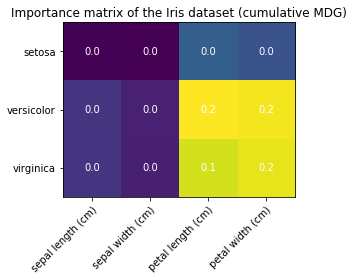

In [9]:
###Using importanceMatrix.calcImportanceMatrix which is the same as calcImportanceMatrix_v2
fig, ax = plt.subplots()
im = ax.imshow(imp_mat_old)

# adding figure annotations
ax.set_xticks(np.arange(imp_mat_old.shape[1]))
ax.set_yticks(np.arange(imp_mat_old.shape[0]))
ax.set_xticklabels(list(iris.feature_names))
ax.set_yticklabels(list(iris.target_names))

# rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# create text annotations over the heatmap
for i in range(len(list(iris.target_names))):
    for j in range(len(list(iris.feature_names))):
        text = ax.text(j, i, round(imp_mat_old[i, j], 1), ha="center", va="center", color="w")

ax.set_title("Importance matrix of the Iris dataset (cumulative MDG)")
fig.tight_layout()
plt.show()

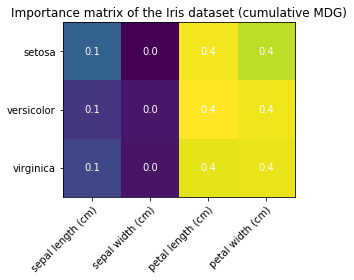

In [10]:
###Using calcImportanceMatrix
fig, ax = plt.subplots()
im = ax.imshow(imp_mat)

# adding figure annotations
ax.set_xticks(np.arange(imp_mat.shape[1]))
ax.set_yticks(np.arange(imp_mat.shape[0]))
ax.set_xticklabels(list(iris.feature_names))
ax.set_yticklabels(list(iris.target_names))

# rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# create text annotations over the heatmap
for i in range(len(list(iris.target_names))):
    for j in range(len(list(iris.feature_names))):
        text = ax.text(j, i, round(imp_mat[i, j], 1), ha="center", va="center", color="w")

ax.set_title("Importance matrix of the Iris dataset (cumulative MDG)")
fig.tight_layout()
plt.show()
    

To interpret this heatmap, it is helpful to understand the underlying data. The iris data set (more [here](https://en.wikipedia.org/wiki/Iris_flower_data_set)) contains 150 observations of 3 different types of iris flowers (l. etosa, l. veriscolor, and l. virginica). For each flower, the sepal length and width, and the petal length and width, are recorded.  

Therefore, we see that petal length and petal width are _very_ important foe each class, suggesting that petal metrics are more important than the sepal metrics to distinguish the flower species.

## Check for robustness
Check for robustness by using PIBC on another dataset (in this case the wine dataset from Sci-Kit Learn, described [here](https://archive.ics.uci.edu/ml/datasets/wine) by UCI).

In [20]:
# load and split the data
wines = load_wine()
X = wines.data
y = wines.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# train the classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 

# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))


Mean Absolute Error: 0.0
Model Accuracy: 100.0


In [22]:
wines.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

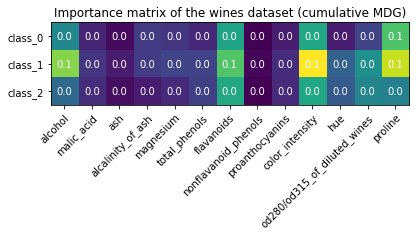

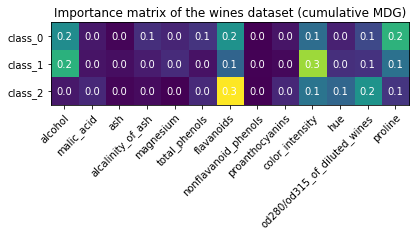

In [12]:
###IMPORTANCE MATRIX - OLD VS NEW VERSION

# calculate the OLD importance matrix
imp_mat = calcImportanceMatrix_old(rf_clf)

# plot the result
fig, ax = plt.subplots()
im = ax.imshow(imp_mat)

# adding figure annotations
ax.set_xticks(np.arange(imp_mat.shape[1]))
ax.set_yticks(np.arange(imp_mat.shape[0]))
ax.set_xticklabels(list(wines.feature_names))
ax.set_yticklabels(list(wines.target_names))

# rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# create text annotations over the heatmap
for i in range(len(list(wines.target_names))):
    for j in range(len(list(wines.feature_names))):
        text = ax.text(j, i, round(imp_mat[i, j], 1), ha="center", va="center", color="w")

ax.set_title("Importance matrix of the wines dataset (cumulative MDG)")
fig.tight_layout()
plt.show()



# calculate the importance matrix
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)

# plot the result
fig, ax = plt.subplots()
im = ax.imshow(imp_mat)

# adding figure annotations
ax.set_xticks(np.arange(imp_mat.shape[1]))
ax.set_yticks(np.arange(imp_mat.shape[0]))
ax.set_xticklabels(list(wines.feature_names))
ax.set_yticklabels(list(wines.target_names))

# rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# create text annotations over the heatmap
for i in range(len(list(wines.target_names))):
    for j in range(len(list(wines.feature_names))):
        text = ax.text(j, i, round(imp_mat[i, j], 1), ha="center", va="center", color="w")

ax.set_title("Importance matrix of the wines dataset (cumulative MDG)")
fig.tight_layout()
plt.show()

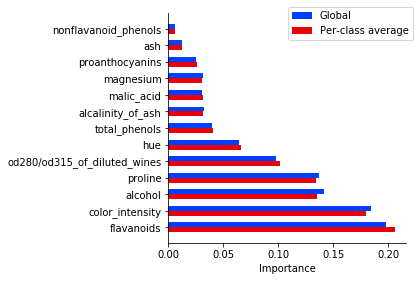

In [15]:
###GLOBAL VS PER-CLASS AVERAGE IMPORTANCE
fig, ax = plt.subplots()
global_importance = rf_clf.feature_importances_
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
mean_importance = np.mean(imp_mat, axis=0)
imp_index = np.argsort(mean_importance)
height = 0.3
y_g = np.arange(len(imp_index))[::-1] + (height / 2.)
y_m = np.arange(len(imp_index))[::-1] - (height / 2.)
ax.barh(y=y_g, width=global_importance[imp_index], height=height,
        color=sns.color_palette('bright')[0], label='Global')
ax.barh(y=y_m, width=mean_importance[imp_index], height=height,
        color=sns.color_palette('bright')[3], label='Per-class average')
ax.set_xlabel('Importance')
ax.set_yticks(np.arange(len(imp_index))[::-1])
ax.set_yticklabels(np.array(wines.feature_names)[imp_index])
ax.legend(bbox_to_anchor=(1.05, 1.05))
sns.despine(fig=fig)
fig.tight_layout()
#fig.savefig(proj_dir+'/2_output/img/GO_log10p_bars.pdf', bbox_inches='tight')
plt.show()

__Result:__ The per-class importance, averaged over the classes for each feature, leads to a feature ranking that is similar to the ranking from the global importance.

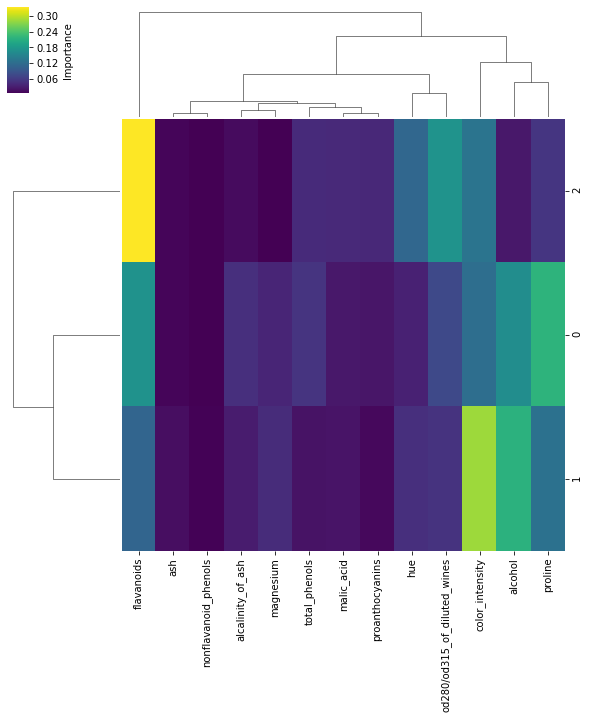

In [18]:
#Heatmap
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
#X_train, y_train
df_imp_mat = pd.DataFrame(imp_mat, columns=wines.feature_names)
cluster_heatmap = sns.clustermap(df_imp_mat, cmap="viridis",
                                 method='average',
                                 cbar_kws={'label':'Importance'},
                                 col_cluster=True, row_cluster=True,
                                 yticklabels=True)
                                 #mask = mask_non_significant)
#cluster_heatmap.savefig('Importance_matrix_heatmap.pdf', bbox_inches='tight')
plt.show()
plt.close()

__Result:__ The combination of the importance heatmap with an hierarchical clustering enable the visualisation of features that have similar importance profile across classes, and the grouping of classes that are discriminated with similar importance across features.

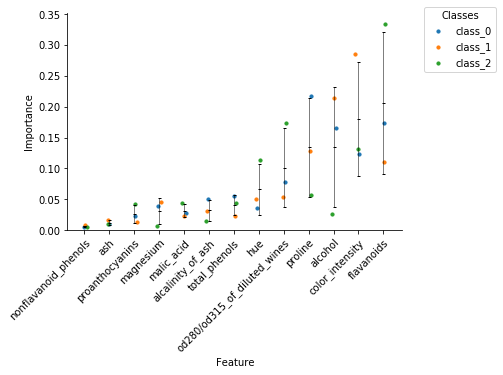

In [19]:
#importance distribution over features
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
mean_imp = np.mean(imp_mat, axis=0)
std_imp = np.std(imp_mat, axis=0, ddof=1)
df_imp_mat = pd.DataFrame(imp_mat, columns=wines.feature_names)
feature_index = np.argsort(mean_imp)
features_reord = np.array(wines.feature_names)[feature_index]

marker_lst = [
    "o", "v", "^", "<", ">", "1", "2", "3", "4",
    "8", "s", "p", "P", "*", "h", "H", "+", "x",
    "X", "D", "d"
]
color_lst = sns.color_palette(n_colors=10)
color_marker_lst = np.array([(c,m) for m in marker_lst for c in color_lst])

fig, ax = plt.subplots()
for j,i in enumerate(feature_index):
    ax.plot([j,j,j], [mean_imp[i]+std_imp[i], mean_imp[i], mean_imp[i]-std_imp[i]],
            marker='_', color='k', ls='-', lw=0.5, ms=3)
for j in np.arange(len(imp_mat)):
    ax.scatter(np.arange(len(feature_index))+np.random.uniform(-1, 1, size=len(feature_index))*.25/2.,
               imp_mat[j,feature_index],
               color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=10, label=wines.target_names[j])
    
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Classes')
ax.set_xticks(np.arange(len(feature_index)))
ax.set_xticklabels(features_reord, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig('Importance_matrix_distribution.pdf', bbox_inches='tight')
plt.show()

__Result:__ Distribution of feature importance over the classes. Features are sorted by their average importance across classes. This plot provides another visual cue as to what features are important globally, and to which class in particular.

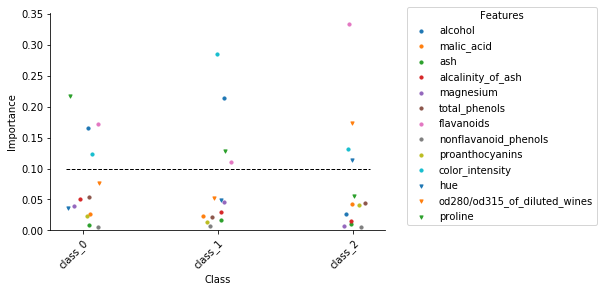

In [20]:
#importance distribution over classes
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
#mean_imp = np.mean(imp_mat, axis=1)
#std_imp = np.std(imp_mat, axis=1, ddof=1)
#class_index = np.argsort(mean_imp)
#classes_reord = np.array(wines.target_names)[class_index]
classes = np.array(wines.target_names)
features = np.array(wines.feature_names)

marker_lst = [
    "o", "v", "^", "<", ">", "1", "2", "3", "4",
    "8", "s", "p", "P", "*", "h", "H", "+", "x",
    "X", "D", "d"
]
color_lst = sns.color_palette(n_colors=10)
color_marker_lst = np.array([(c,m) for m in marker_lst for c in color_lst])

fig, ax = plt.subplots()
#for j,i in enumerate(class_index):
#    ax.plot([j]*len(mean_imp), [mean_imp[i]+std_imp[i], mean_imp[i], mean_imp[i]-std_imp[i]],
#            marker='_', color='k', ls='-', lw=0.5, ms=3)
#for j in np.arange(len(features)):
#    ax.scatter(np.arange(len(class_index))[class_index] + np.random.uniform(-1,1,size=len(class_index))*.25/2.,
#               imp_mat[class_index,j],
#               color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
#               s=10, label=features[j])
for j in np.arange(len(features)):
    ax.scatter(np.arange(len(classes)) + np.random.uniform(-1,1,size=len(classes))*.25/2.,
               imp_mat[:,j],
               color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=10, label=features[j])
ax.hlines(y=0.1, xmin=-.25/2., xmax=len(classes)-1+.25/2., colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features')
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Class')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig('Importance_matrix_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

__Result:__ Distributions of features' importance within each class. Classes are sorted  by the average importance across classes [THIS SORTING DOES OT MAKE SENSE!]
This plot guides feature selection
Select top 3 features for every class
Select top global features plus

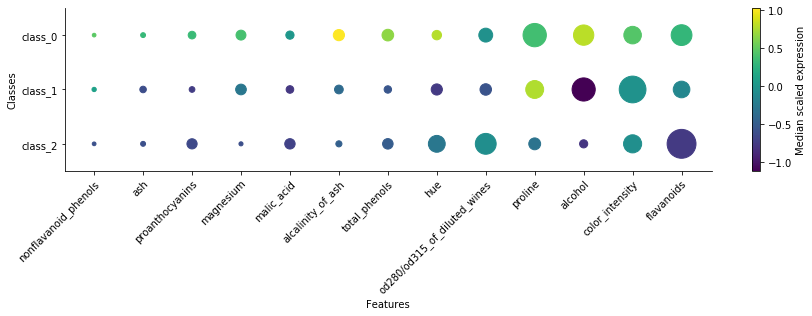

In [23]:
#Feature importance and median expression
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)

#Order classes #SHOULD REMOVE THIS
mean_imp_per_class = np.mean(imp_mat, axis=1)
class_index = np.argsort(mean_imp_per_class)
classes_reord = np.arange(len((wines.target_names)))[class_index]
classes_name_reord = np.array(wines.target_names)[class_index]
classes = np.array(wines.target_names)
#Order features
mean_imp_per_feat = np.mean(imp_mat, axis=0)
feat_index = np.argsort(mean_imp_per_feat)
features = np.array(wines.feature_names)
feat_reord = features[feat_index]

imp_mat_reord = imp_mat[class_index,:]
imp_mat_reord = imp_mat_reord[:,feat_index]

norm_X = scale(X)

x_pos = np.hstack([np.arange(1,len(feat_reord)+1) for k in range(len(classes_reord))])
y_pos = np.hstack([np.ones(len(feat_reord))*(k+1) for k in range(len(classes_reord))])
sizes = imp_mat_reord * 2500
#sizes = np.ones(np.shape(imp_mat_reord)) * 2500
#norm_X[y==cl][f_ind] SHOULD BE norm_X[y==cl,f_ind]
medians = np.array([np.median(norm_X[y==cl][f_ind]) for cl in classes_reord for f_ind in feat_index])
fig, ax = plt.subplots(figsize=(len(feat_reord)+1.5, len(classes_reord)))
sc = ax.scatter(x=x_pos, y=y_pos, s=sizes, c=medians, cmap='plasma')

#ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features')
plt.colorbar(sc, label='Median scaled expression')
ax.set_yticks(np.arange(1,len(classes_reord)+1))
ax.set_yticklabels(classes_name_reord)
ax.set_xticks(np.arange(1,len(feat_reord)+1))
ax.set_xticklabels(feat_reord, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Classes')
ax.set_xlabel('Features')

ax.set_ylim(bottom=0.5, top=len(classes_reord)+0.5)
sns.despine(fig=fig)
#fig.savefig('Importance_matrix_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()


__Result:__ Per-class feature importance and expression. Dots' color and size represent, respectively, the median expression (for the centred and scaled data) and the importance of a feature for a given class.
[SORTING] Visual cue for 

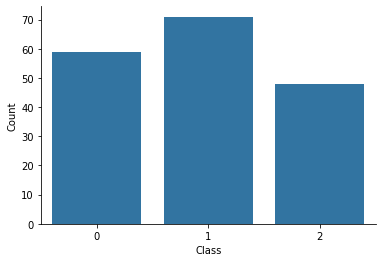

In [24]:
###Class count plot
fig, ax = plt.subplots()
sns.countplot(y, color=sns.color_palette()[0], ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Class')
sns.despine(fig=fig)

__Result:__ Histogram for the number of observation in a given class from te wine data, showing the dataset is imbalanced.

In [25]:
#FEATURE SELECTION from Global vs from per-class importance 

X = wines.data
y = wines.target

top_global = ['flavanoids', 'color_intensity', 'alcohol', 'proline']
feat_ind_global = np.array([feat in top_global for feat in wines.feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind_global], y, random_state=42)
# train the classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))
print(confusion_matrix(y_true=y_test, y_pred=predictions))
#print(classification_report(y_true=y_test, y_pred=predictions))

top_class2 = ['flavanoids', 'color_intensity', 'alcohol', 'od280/od315_of_diluted_wines']
feat_ind_class2 = np.array([feat in top_class2 for feat in wines.feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind_class2], y, random_state=42)
# train the classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))
print(confusion_matrix(y_true=y_test, y_pred=predictions))
#print(classification_report(y_true=y_test, y_pred=predictions))

Mean Absolute Error: 0.02
Model Accuracy: 97.78
[[15  0  0]
 [ 0 18  0]
 [ 0  1 11]]
Mean Absolute Error: 0.02
Model Accuracy: 97.78
[[15  0  0]
 [ 1 17  0]
 [ 0  0 12]]
